In [1]:
import pandas as pd
import pybasilica.run as run
import torch
import pyro
import numpy as np
import seaborn as sns
import sklearn.metrics
import torch.nn.functional as F

%load_ext autoreload
%autoreload 2

/Users/elenab/Library/r-miniconda-arm64/envs/basilica-env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
m_g = pd.read_csv("test_datasets/counts_sbs.N150.G3.csv")
m_sbs = m_g.drop(["groups"], axis=1)
g_sbs = m_g["groups"].tolist()
cosmic_sbs = pd.read_csv("test_datasets/COSMIC_filt.csv", index_col=0) 

In [3]:
m_g = pd.read_csv("test_datasets/counts_dbs.N150.G3.csv")
m_dbs = m_g.drop(["groups"], axis=1)
g_dbs = m_g["groups"].tolist()
cosmic_dbs = pd.read_csv("test_datasets/COSMIC_dbs.csv", index_col=0) 

In [ ]:
dn_sbs = torch.tensor(cosmic_sbs.loc[["SBS6","SBS17b"]].values, dtype=torch.float64)
ref_sbs = torch.tensor(cosmic_sbs.loc[["SBS1","SBS2","SBS5"]].values, dtype=torch.float64)
k_denovo = dn_sbs.shape[0]
k_fixed = ref_sbs.shape[0]

def mix_weights(beta):
    '''
    Function used for the stick-breaking process.
    '''
    beta1m_cumprod = (1 - beta).cumprod(-1)
    return F.pad(beta, (0, 1), value=1) * F.pad(beta1m_cumprod, (1, 0), value=1)

with pyro.plate("beta_d_plate", k_denovo):
    pi_beta = pyro.sample("beta", pyro.distributions.Beta(torch.ones(k_fixed, dtype=torch.float64), 1.5).to_event(1))
    print(pi_beta)
    pi = mix_weights(pi_beta)

print(pi.shape)
print(pi)

In [4]:
obj_sbs = run.fit(
    x=m_sbs, 
    k_list=[2], 
    lr=0.005, 
    optim_gamma=0.1,
    n_steps=100, 
    # cluster=6,
    dirichlet_prior=True,
    beta_fixed=cosmic_sbs.loc[["SBS1","SBS5"]], 
    # hyperparameters={"penalty_scale":2},
    enforce_sparsity = True, 
    reg_weight=0., 
    store_parameters = False, 
    seed_list=[30],
    nonparametric=True,
    store_fits=True
    )


ELBO 633995.992386: 100%|██████████| 100/100 [00:01<00:00, 51.17it/s]


<Axes: >

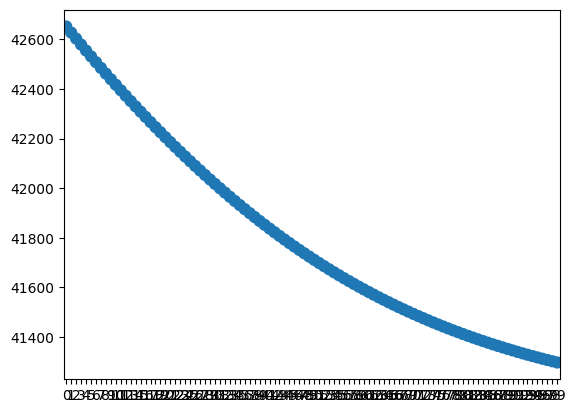

In [84]:
sns.pointplot(x=[_ for _ in range(100)], y=obj_sbs.regs) 

<Axes: >

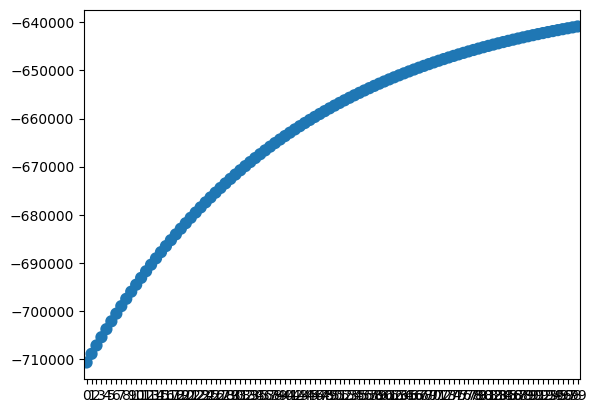

In [71]:
sns.pointplot(x=[_ for _ in range(100)], y=obj_sbs.likelihoods) 

<Axes: >

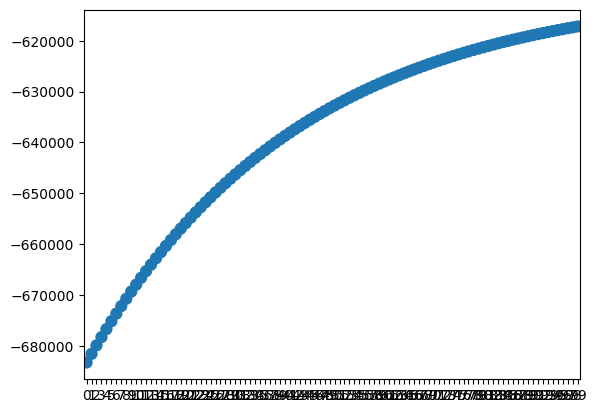

In [72]:
sns.pointplot(x=[_ for _ in range(100)], y=[obj_sbs.likelihoods[i]+obj_sbs.regs[i] for i in range(100)]) 

<Axes: >

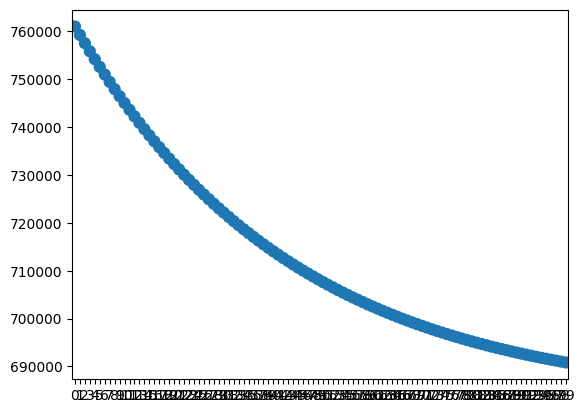

In [56]:
sns.pointplot(x=[_ for _ in range(100)], y=obj_sbs.losses) 

In [57]:
print(obj_sbs.init_params["beta_weights"])
print(obj_sbs.params["beta_w"]) 

        SBS1      SBS5        DN
D1  0.073176  0.874404  0.052420
D2  0.527325  0.400127  0.072548
D3  0.245231  0.104793  0.649976
        SBS1      SBS5        DN
D1  0.102035  0.824341  0.073624
D2  0.527846  0.371445  0.100710
D3  0.187439  0.079889  0.732671


In [ ]:
print(obj_sbs.init_params["beta_weights"])
print(obj_sbs.params["beta_w"]) 

In [ ]:
print(obj_sbs.params["alpha"])

In [ ]:
print(obj_sbs.params["alpha_star"])

In [ ]:
print(obj_sbs.params["alpha"])

In [ ]:
dn = torch.tensor(obj_sbs.params["beta_d"].values)
sbs1 = torch.tensor(cosmic_sbs.loc[["SBS1"]].values)
for i in range(dn.shape[0]):
    print(torch.nn.functional.cosine_similarity(sbs1, dn[i,:]))

In [ ]:
a_orig = pyro.distributions.Dirichlet(torch.tensor([1., 5.])).sample((100,)) 

In [ ]:
a = a_orig**3
fig, ax = plt.subplots()
sns.scatterplot(x=a[:,0].tolist(), y=a[:,1].tolist(), ax=ax)
ax.set_xlim(0,1)
ax.set_ylim(0,1) 

In [ ]:
import numpy as np
from scipy.stats import dirichlet

# Define the parameters
alpha = [1, 1, 1]  # Adjust alpha values as needed
power = 2.0  # Adjust the power parameter

# Sample from the standard Dirichlet distribution
sample = np.random.dirichlet(alpha)

# Apply the transformation
sample_away_from_mode = sample ** (1 / power)

print("Sampled value away from the mode:", sample_away_from_mode)
print("Sampled:", sample)


In [ ]:
import torch
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam

# Define the parameters of the Dirichlet distribution
alpha = torch.tensor([1.0, 5.0, 1.0])  # Replace with your alpha values

# Sample from the Dirichlet distribution
sampled_value = pyro.sample("sampled_value", dist.Dirichlet(alpha))

print("Sampled value away from the mode:", sampled_value)

# Find the mode of the Dirichlet distribution
mode = torch.argmax(alpha)

print("Mode", mode)

# Create a mask to zero out the mode value
mask = torch.ones_like(sampled_value)
mask[mode] = 0

# Zero out the mode value
sampled_value = sampled_value * mask

# Renormalize to make it a valid probability distribution
sampled_value = sampled_value / sampled_value.sum()

print("Sampled value away from the mode:", sampled_value)


In [ ]:
# a = a_orig**(3)
fig2, ax2 = plt.subplots()
fig3, ax3 = plt.subplots()
sns.histplot(a[:,0].tolist(), ax=ax2)
sns.histplot(a[:,1].tolist(), ax=ax3)
ax2.set_xlim(0,1)
ax3.set_xlim(0,1)

In [ ]:
torch.sum(fixed, dim=0)

In [ ]:
fixed = torch.tensor(obj_sbs.beta_fixed.values)
beta_w = torch.tensor(obj_sbs.params["beta_w"].values)
denovo = torch.tensor(obj_sbs.params["beta_d"].values)
cum_weights = torch.ones((obj_sbs.k_denovo, obj_sbs.k_fixed))/obj_sbs.k_fixed

fixed_cum = obj_sbs._get_unique_beta_stick_breaking(beta_fixed=fixed, beta_denovo=None, beta_weights=cum_weights)
fixed_cum = obj_sbs._norm_and_clamp(fixed_cum)

print(torch.sum((fixed_cum * (torch.abs(fixed_cum - denovo)))) * torch.tensor(obj_sbs.x.values).sum())
print(torch.sum((fixed_cum * (torch.abs(fixed_cum - denovo)))) * obj_sbs.x.shape[0] * obj_sbs.x.shape[1])


In [ ]:
obj_sbs.losses

In [ ]:
len(obj_sbs.train_params)

In [ ]:
pyro.distributions.Dirichlet(fixed_cum*1000).log_prob(denovo) 

In [ ]:
obj_sbs.gradient_norms.keys()

In [ ]:
## self.x.sum() * torch.sum(beta_fixed_cum * (1 - torch.abs(beta_fixed_cum - beta_denovo)))
obj_sbs.params["beta_w"] 

In [ ]:
## self.x.sum() * torch.sum(beta_fixed_cum * (torch.abs(beta_fixed_cum - beta_denovo)))
obj_sbs.params["beta_w"] 

In [ ]:
## self.x.sum() * torch.sum(beta_fixed_cum * (torch.abs(beta_fixed_cum - beta_denovo)))
obj_sbs.params["beta_w"] 

In [ ]:
## self.n_samples * self.contexts * pyro.distributions.Dirichlet(beta_fixed_cum*1000).to_event(1).log_prob(beta_denovo))
obj_sbs.params["beta_w"] 

In [ ]:
pyro.param("beta_weights")

In [ ]:
obj_sbs.params["beta_w"] 

In [ ]:
obj_sbs.gradient_norms.keys() 

In [ ]:
obj_sbs.params["alpha"].sum(axis=1)

In [ ]:
k_dn = 2
k_f = 3
n_samples = 5
beta_weights = pyro.distributions.Dirichlet(torch.ones(k_dn, k_f+1)).sample()
alpha_star = pyro.distributions.Dirichlet(torch.ones(n_samples, k_dn)).sample()
print("beta weights\n", beta_weights)
print("alpha star\n", alpha_star)

In [ ]:
beta_weights[1,2]

In [ ]:
alpha = torch.zeros((n_samples, k_dn+k_f))

for n in range(n_samples):
    for j in range(k_dn):
        for r in range(k_f):
            alpha[n, r] += torch.sum(alpha_star[n,j]) * beta_weights[j,r]
        
        for d in range(k_f, k_f+k_dn):
            alpha[n, d] += torch.sum(alpha_star[n,j]) * beta_weights[j,-1]

print(alpha)

In [ ]:
obj_sbs.params["beta_w"]

In [ ]:
obj_sbs.params["beta_d"]

In [ ]:
obj_dbs = run.fit(
    x=m_dbs, 
    k_list=3, 
    lr=0.005, 
    optim_gamma=0.1,
    n_steps=10, 
    # cluster=6, 
    dirichlet_prior=True,
    beta_fixed=cosmic_dbs.loc[["DBS4"]], 
    hyperparameters={"alpha_sigma":.15, "alpha_p_sigma":1., "alpha_p_conc0":0.6, 
                     "alpha_p_conc1":0.6, "alpha_rate":1., "pi_conc0":0.5, "alpha_conc":100,
                     "scale_factor_alpha":10000, "scale_factor_centroid":1000, "scale_tau":0},
    enforce_sparsity = True, 
    reg_weight=0., 
    store_parameters = True, 
    seed_list=[92],
    nonparametric=True,
    store_fits=True
    )


In [ ]:
alpha_sbs = obj_sbs.params["alpha"] 
alpha_dbs = obj_dbs.params["alpha"] 

In [ ]:
input = [alpha_sbs, alpha_dbs] 
input_tensor = [torch.tensor(alpha_sbs.values), torch.tensor(alpha_dbs.values)]
max_shape = max([i.shape[1] for i in input_tensor])
# stacked = torch.stack(input_tensor)

In [ ]:
mixture = run.fit(
    alpha=input, 
    lr=0.005, 
    optim_gamma=0.1,
    n_steps=3000,
    cluster=5, 
    hyperparameters={"alpha_sigma":.15, "alpha_p_sigma":1., "alpha_p_conc0":0.6, 
                     "alpha_p_conc1":0.6, "alpha_rate":1., "pi_conc0":0.5, "alpha_conc":100,
                     "scale_factor_alpha":10000, "scale_factor_centroid":1000, "scale_tau":0},
    store_parameters = True, 
    seed_list=[92],
    nonparametric=True,
    store_fits=True
    )


In [ ]:
import torch.nn.functional as F
def mix_weights(beta):
    '''
    Function used for the stick-breaking process.
    '''
    print("beta =", beta)
    beta1m_cumprod = (1 - beta).cumprod(-1)
    print("beta1m_cumprod =", beta1m_cumprod)
    res1 = F.pad(beta, (0, 1), value=1)
    res2 = F.pad(beta1m_cumprod, (1, 0), value=1)
    res = res1 * res2
    print(f"res1 = {res1}, res2 = {res2}, res = {res}\n")
    return res


In [ ]:
cluster = 6
with pyro.plate("beta_plate", cluster-1):
    pi_beta = pyro.sample(f"beta", pyro.distributions.Beta(1, 1.1755e-36))
    # pi_beta = torch.tensor([1.1755e-36, 2.1648e-18, 1.1755e-36, 6.6389e-33, 1.1755e-36])
    print("pi_beta =", pi_beta)
    pi = mix_weights(pi_beta)

print(pi)

In [ ]:
beta_star = torch.zeros(k_denovo, 96, dtype=torch.float64) 
for i in range(k_denovo):
    tmp_sbs = torch.cat((ref_sbs, dn_sbs[i].unsqueeze(0)))
    beta_star[i] = pi[i].unsqueeze(0).matmul(tmp_sbs) 

In [ ]:
pyro.distributions.Gamma(0.01, 0.01).sample((5,))

In [ ]:
pyro.distributions.Dirichlet(torch.ones(5)).sample()

In [ ]:
(1 - pyro.distributions.Beta(1, 1e-10).sample((cluster-1,))).cumprod(-1)

In [ ]:
pi = torch.zeros((10,))
pi[:5] = 5
pi 

In [ ]:
alpha_centr = mixture[0].params["alpha_prior"]
print(alpha_centr) 

In [ ]:
print(sklearn.metrics.normalized_mutual_info_score(mixture.groups, g_sbs)) 
print(sklearn.metrics.normalized_mutual_info_score(mixture.groups, g_dbs)) 

In [ ]:
print(obj_sbs.params["scale_factor_centroid"])
print(obj_sbs.params["scale_factor_alpha"]) 

In [ ]:
obj_sbs.params

In [ ]:
obj_sbs.train_params[6]["scale_factor_centroid"]

In [ ]:
obj_sbs.params["pi_conc0"] 

In [ ]:
sns.scatterplot(x=range(len(obj_sbs.likelihoods)), y=obj_sbs.likelihoods) 

In [ ]:
sns.scatterplot(x=range(len(obj_sbs.losses)), y=obj_sbs.losses) 

In [ ]:
try: sns.scatterplot(x=range(len(obj_sbs.gradient_norms["scale_factor_centroid_param"])), 
                     y=obj_sbs.gradient_norms["scale_factor_centroid_param"]) 
except: print() 

In [ ]:
try: sns.scatterplot(x=range(len(obj_sbs.gradient_norms["scale_factor_alpha_param"])), 
                     y=obj_sbs.gradient_norms["scale_factor_alpha_param"]) 
except: print() 

In [ ]:
try: sns.scatterplot(x=range(len(obj_sbs.gradient_norms["alpha_prior_param"])), y=obj_sbs.gradient_norms["alpha_prior_param"]) 
except: print() 

In [ ]:
try: sns.scatterplot(x=range(len(obj_sbs.gradient_norms["alpha_prior_param"])), y=obj_sbs.gradient_norms["alpha_prior_param"]) 
except: print() 

In [ ]:
try: sns.scatterplot(x=range(len(obj_sbs.gradient_norms["pi_param"])), y=obj_sbs.gradient_norms["pi_param"]) 
except: print() 

In [ ]:
try: sns.scatterplot(x=range(len(obj_sbs.gradient_norms["pi_conc0_param"])), y=obj_sbs.gradient_norms["pi_conc0_param"]) 
except: print() 

In [ ]:
try: sns.scatterplot(x=range(len(obj_sbs.gradient_norms["alpha"])), y=obj_sbs.gradient_norms["alpha"]) 
except: print() 

In [ ]:
try: sns.scatterplot(x=range(len(obj_sbs.gradient_norms["beta_denovo"])), y=obj_sbs.gradient_norms["beta_denovo"])
except: print()

In [ ]:
pd.DataFrame(np.array(obj_sbs.init_params["alpha_prior_param"]), columns=obj_sbs.params["alpha"].columns).plot.bar(stacked=True, legend=False) 

In [ ]:
try: pd.DataFrame(np.array(obj_sbs.params["alpha_prior"]), columns=obj_sbs.params["alpha_prior"].columns).plot.bar(stacked=True, legend=False) 
except Exception as e: print() 

In [ ]:
try:
    for gid in set(np.array(obj_sbs.groups)):
        tmp = [i for i, v in enumerate(obj_sbs.groups) if v == gid]
        # tmp = [i for i, v in enumerate(obj_sbs.groups) if (v == gid and i in idxs)]
        if len(tmp) == 0: continue
        pd.DataFrame(np.array(obj_sbs.params["alpha"]), columns=obj_sbs.params["alpha"].columns, 
                     index=obj_sbs.params["alpha"].index).iloc[tmp].plot.bar(stacked=True)
except Exception as e:
    print(e)
    obj_sbs.alpha.plot.bar(stacked=True, legend=False) 


In [ ]:
try:
    for sbs in pd.concat((obj_sbs.params["beta_f"], obj_sbs.params["beta_d"])).index:
        pd.concat((obj_sbs.params["beta_f"], obj_sbs.params["beta_d"])).loc[[sbs]].transpose().plot.bar()
except Exception as e:
    print(e)